In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib

# Display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

print('Libraries loaded')

Libraries loaded


In [32]:
# Load dataset
df = pd.read_csv('customer_churn_data.csv')

# Basic checks
print('Shape:', df.shape)
df.head()

Shape: (10000, 24)


,customer_id,age,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,customer_satisfaction,support_calls,churn
0,CUST_000001,52,Male,0,Yes,Yes,7,Yes,No,Fiber optic,Yes,No,No,Yes,Yes,No,One year,Yes,Electronic check,39.18,294.66,4,3,No
1,CUST_000002,42,Male,0,Yes,No,32,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Electronic check,40.36,1286.75,3,1,No
2,CUST_000003,54,Male,0,No,Yes,12,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,No,Bank transfer (automatic),84.77,947.09,2,3,Yes
3,CUST_000004,67,Male,1,No,No,3,Yes,No,DSL,No,Yes,No,No,No,No,One year,No,Credit card (automatic),54.14,172.76,4,5,No
4,CUST_000005,41,Female,0,Yes,No,7,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,71.77,466.98,3,3,No


In [33]:
# Info and missing values
print(df.info())
print('\nMissing values per column:\n', df.isnull().sum())

# Summary statistics
print('\nNumeric summary:')
print(df.describe())
print('\nCategorical summary:')
print(df.describe(include=[object]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            10000 non-null  object 
 1   age                    10000 non-null  int64  
 2   gender                 10000 non-null  object 
 3   senior_citizen         10000 non-null  int64  
 4   partner                10000 non-null  object 
 5   dependents             10000 non-null  object 
 6   tenure                 10000 non-null  int64  
 7   phone_service          10000 non-null  object 
 8   multiple_lines         10000 non-null  object 
 9   internet_service       10000 non-null  object 
 10  online_security        10000 non-null  object 
 11  online_backup          10000 non-null  object 
 12  device_protection      10000 non-null  object 
 13  tech_support           10000 non-null  object 
 14  streaming_tv           10000 non-null  object 
 15  str

In [34]:
# Example cleaning
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill numeric missing with median
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# If 'Churn' is object, keep it as target
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')

# Fill
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

print('Missing values after simple fill:')
print(df.isnull().sum())

Missing values after simple fill:
customer_id              0
age                      0
gender                   0
senior_citizen           0
partner                  0
dependents               0
tenure                   0
phone_service            0
multiple_lines           0
internet_service         0
online_security          0
online_backup            0
device_protection        0
tech_support             0
streaming_tv             0
streaming_movies         0
contract                 0
paperless_billing        0
payment_method           0
monthly_charges          0
total_charges            0
customer_satisfaction    0
support_calls            0
churn                    0
dtype: int64


In [36]:
# Churn distribution
if 'Churn' in df.columns:
    print('Churn value counts:\n', df['churn'].value_counts())
    print('\nChurn rate:')
    print(df['churn'].value_counts(normalize=True))

# Example plots (uncomment to run)
# plt.figure(figsize=(6,4))
# df['Churn'].value_counts().plot(kind='bar')
# plt.title('Churn distribution')
# plt.show()

# Demographic breakdown example
for col in ['gender','senior_citizen','partner','dependents']:
    if col in df.columns:
        print('\nBreakdown by', col)
        print(pd.crosstab(df[col], df['churn'], normalize='index'))

# Tenure and charges relationship
for col in ['tenure','monthly_charges','total_charges']:
    if col in df.columns:
        print('\nStatistics for', col)
        print(df.groupby('churn')[col].describe())

# Correlation for numeric features
print('\nNumeric correlations:')
print(df.select_dtypes(include=[np.number]).corr())


Breakdown by gender
churn         No       Yes
gender                    
Female  0.778004  0.221996
Male    0.767780  0.232220

Breakdown by senior_citizen
churn                 No       Yes
senior_citizen                    
0               0.776358  0.223642
1               0.737811  0.262189

Breakdown by partner
churn          No       Yes
partner                    
No       0.760851  0.239149
Yes      0.783593  0.216407

Breakdown by dependents
churn             No       Yes
dependents                    
No          0.757259  0.242741
Yes         0.808907  0.191093

Statistics for tenure
        count       mean        std  min  25%   50%   75%   max
churn                                                          
No     7728.0  24.095238  20.167610  1.0  8.0  19.0  35.0  72.0
Yes    2272.0  15.827465  17.831176  1.0  3.0   9.0  22.0  72.0

Statistics for monthly_charges
        count       mean        std    min      25%    50%      75%     max
churn                           

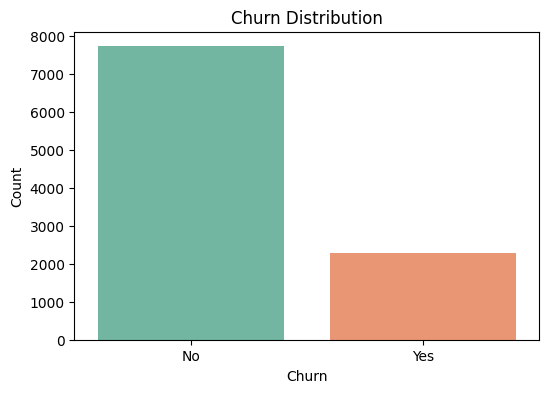

<Figure size 600x400 with 0 Axes>

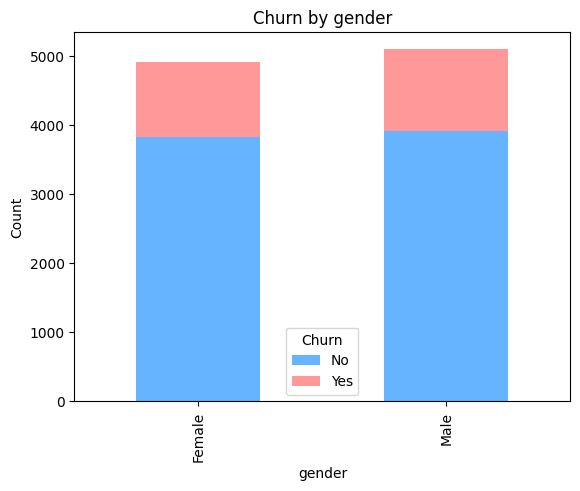

<Figure size 600x400 with 0 Axes>

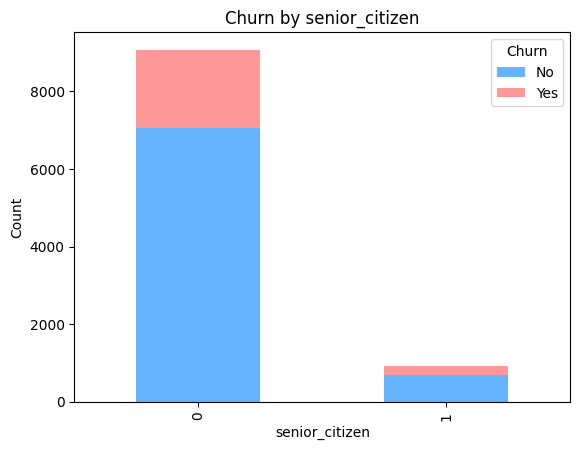

<Figure size 600x400 with 0 Axes>

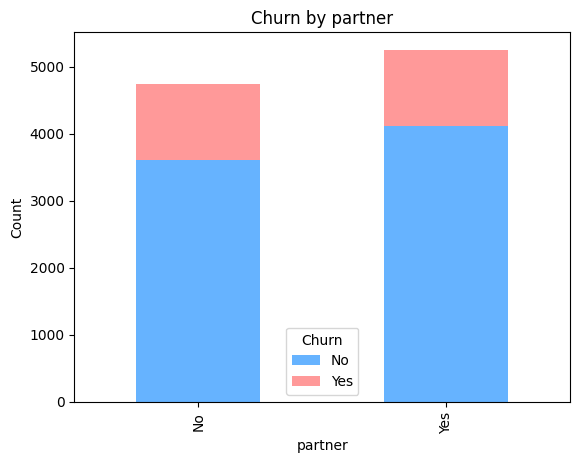

<Figure size 600x400 with 0 Axes>

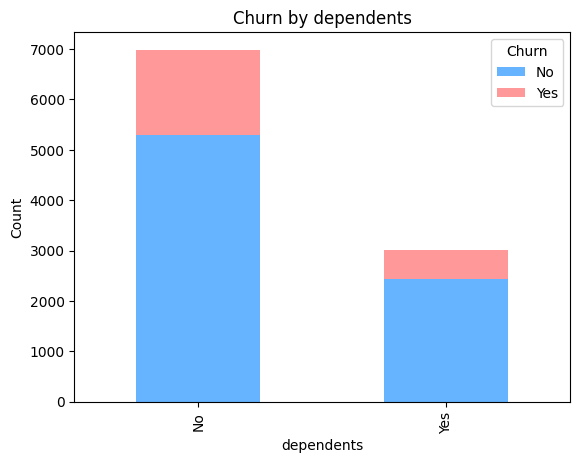

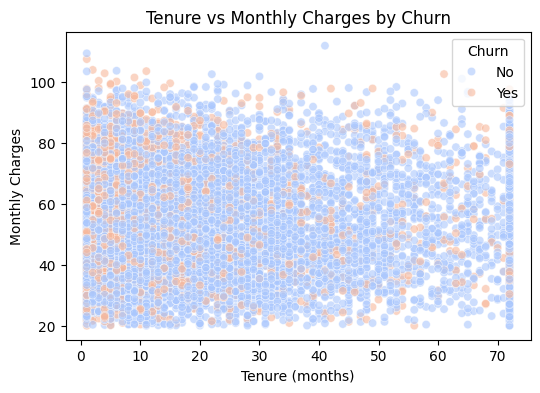

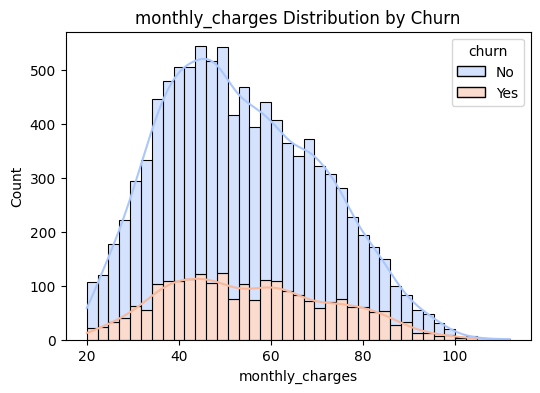

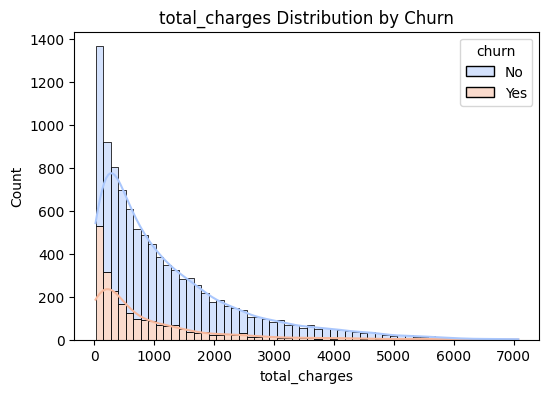

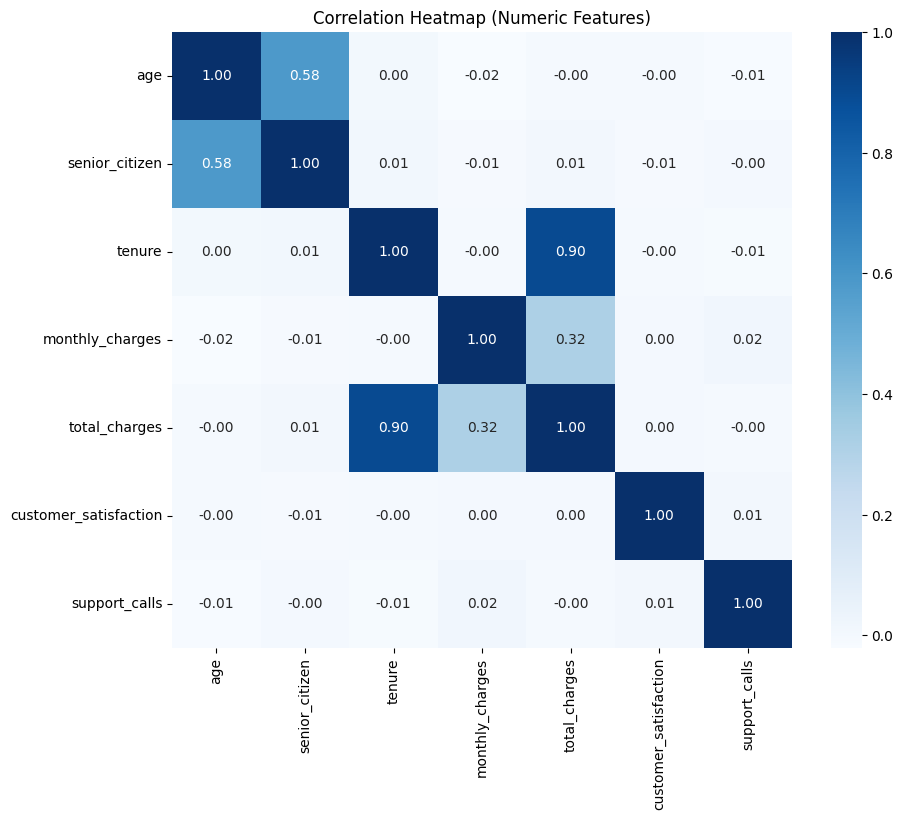

In [40]:
# Ensure plots show in notebook
%matplotlib inline

# 1️⃣ Churn distribution (bar plot)
plt.figure(figsize=(6,4))
sns.countplot(x='churn', data=df, palette='Set2')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# 2️⃣ Demographic breakdown (stacked bars for churn)
demographic_cols = ['gender','senior_citizen','partner','dependents']
for col in demographic_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        churn_counts = pd.crosstab(df[col], df['churn'])
        churn_counts.plot(kind='bar', stacked=True, color=['#66b3ff','#ff9999'])
        plt.title(f'Churn by {col}')
        plt.ylabel('Count')
        plt.xlabel(col)
        plt.legend(title='Churn')
        plt.show()

# 3️⃣ Tenure vs MonthlyCharges (scatter plot)
if 'tenure' in df.columns and 'monthly_charges' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='tenure', y='monthly_charges', hue='churn', data=df, palette='coolwarm', alpha=0.6)
    plt.title('Tenure vs Monthly Charges by Churn')
    plt.xlabel('Tenure (months)')
    plt.ylabel('Monthly Charges')
    plt.legend(title='Churn')
    plt.show()

# 4️⃣ MonthlyCharges & TotalCharges distribution by churn
for col in ['monthly_charges', 'total_charges']:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(data=df, x=col, hue='churn', multiple='stack', kde=True, palette='coolwarm')
        plt.title(f'{col} Distribution by Churn')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

# 5️⃣ Correlation heatmap for numeric features
plt.figure(figsize=(10,8))
numeric_corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(numeric_corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()


In [42]:
# Feature engineering: tenure bins (example)
if 'tenure' in df.columns:
    df['tenure_group'] = pd.cut(df['tenure'], bins=[-1,3,12,24,60,1000], labels=['0-3','4-12','13-24','25-60','60+'])

# Identify final feature lists
target = 'churn'
if target not in df.columns:
    raise ValueError('Target column Churn not found')

X = df.drop(columns=[target])
y = df[target].map({'Yes':1,'No':0}) if df[target].dtype==object else df[target]

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()

print('Numeric features:', num_features)
print('Categorical features:', cat_features)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features)
    ],
    remainder='drop'
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/test sizes:', X_train.shape, X_test.shape)


Numeric features: ['age', 'senior_citizen', 'tenure', 'monthly_charges', 'total_charges', 'customer_satisfaction', 'support_calls']
Categorical features: ['customer_id', 'gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'tenure_group']
Train/test sizes: (8000, 24) (2000, 24)


In [43]:
# Pipelines and parameter grids
models = {
    'LogisticRegression': (LogisticRegression(max_iter=2000), {'clf__C':[0.01,0.1,1,10]}),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {'clf__max_depth':[3,5,10,None], 'clf__min_samples_split':[2,5,10]}),
    'RandomForest': (RandomForestClassifier(random_state=42), {'clf__n_estimators':[50,100], 'clf__max_depth':[5,10,None]}),
    'SVM': (SVC(probability=True), {'clf__C':[0.1,1,10], 'clf__kernel':['rbf','linear']})
}

best_estimators = {}
for name, (estimator, params) in models.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', estimator)])
    gs = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=3, n_jobs=-1)
    print('\nTraining', name)
    gs.fit(X_train, y_train)
    print('Best params:', gs.best_params_)
    print('Best CV f1:', gs.best_score_)
    best_estimators[name] = gs

print('\nTraining complete')


Training LogisticRegression
Best params: {'clf__C': 1}
Best CV f1: 0.3202383460093828

Training DecisionTree
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 5}
Best CV f1: 0.38444840106363515

Training RandomForest
Best params: {'clf__max_depth': None, 'clf__n_estimators': 100}
Best CV f1: 0.12600616227861736

Training SVM
Best params: {'clf__C': 10, 'clf__kernel': 'rbf'}
Best CV f1: 0.3498189735845522

Training complete


In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

results = []
for name, gs in best_estimators.items():
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    results.append((name, acc, prec, rec, f1))
    print(f"\n{name} — Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print('Confusion matrix:\n', cm)

results_df = pd.DataFrame(results, columns=['model','accuracy','precision','recall','f1']).sort_values('f1', ascending=False)
print('\nModel comparison (sorted by F1):')
print(results_df)

# Pick best model
best_model_name = results_df.iloc[0]['model']
final_model = best_estimators[best_model_name].best_estimator_
print('\nSelected best model:', best_model_name)



LogisticRegression — Accuracy: 0.7910, Precision: 0.6169, Recall: 0.2093, F1: 0.3125
Confusion matrix:
 [[1487   59]
 [ 359   95]]

DecisionTree — Accuracy: 0.7410, Precision: 0.4106, Recall: 0.3238, F1: 0.3621
Confusion matrix:
 [[1335  211]
 [ 307  147]]

RandomForest — Accuracy: 0.7840, Precision: 0.6964, Recall: 0.0859, F1: 0.1529
Confusion matrix:
 [[1529   17]
 [ 415   39]]

SVM — Accuracy: 0.7855, Precision: 0.5490, Recall: 0.3084, F1: 0.3949
Confusion matrix:
 [[1431  115]
 [ 314  140]]

Model comparison (sorted by F1):
                model  accuracy  precision    recall        f1
3                 SVM    0.7855   0.549020  0.308370  0.394922
1        DecisionTree    0.7410   0.410615  0.323789  0.362069
0  LogisticRegression    0.7910   0.616883  0.209251  0.312500
2        RandomForest    0.7840   0.696429  0.085903  0.152941

Selected best model: SVM
